<a href="https://colab.research.google.com/github/Ashik9576/NYC-Taxi-Time-Prediction/blob/main/Ashik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# **Imporing the required Libraries**

In [88]:
# Importing the libraries
!pip install pycountry
!pip install haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
import plotly.express as px
from numpy import math
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [53]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Data**

In [54]:
# creating directory path
nyc = pd.read_csv('/content/drive/MyDrive/NYC/NYC Taxi Data.csv')

**Creating Copy of Data**

In [55]:
# creating a copy
nycc=nyc.copy()

# **File Structure and content**

In [56]:
#no. of row and column
print("We have {} rows.".format(nycc.shape[0]))
print("We have {} columns.".format(nycc.shape[1]))
nycc.iloc[1,:]

We have 1458644 rows.
We have 11 columns.


id                              id2377394
vendor_id                               1
pickup_datetime       2016-06-12 00:43:35
dropoff_datetime      2016-06-12 00:54:38
passenger_count                         1
pickup_longitude                 -73.9804
pickup_latitude                   40.7386
dropoff_longitude                -73.9995
dropoff_latitude                  40.7312
store_and_fwd_flag                      N
trip_duration                         663
Name: 1, dtype: object

**At first galance, We have seen that the type of each variable and how they look like.**

# **MISSING VALUES**
Knowing about missing values is important because they indicate how much we dont's know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.


In [57]:
#check null values in Data frame
nyc.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**Fortunately, in this dataset we do not have any missing values which is great**

# **Describing Dataset**

In [58]:
# Visualizing the dataset
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [59]:
# summery of dataframe
nyc.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [60]:
nycc['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [61]:
nycc['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

# **Reformatting features**
There are a variety of fratures within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features.


In [62]:
#converting string to datetime features
nycc['pickup_datetime']=pd.to_datetime(nycc.pickup_datetime)
nycc['dropoff_datetime']=pd.to_datetime(nycc.dropoff_datetime)

#converting yes/no flag to 1 and 0
nycc['store_and_fwd_flag']=1*(nycc.store_and_fwd_flag.values=='Y')

In [63]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435


# **Target Exploration and Data Visualization**
In this section we will take at the trip duration is the target variable. It is crucial to understand it in detail as this is what we ate trying to predict accurately.

In [64]:
nycc['trip_duration'].describe()/3600   # trip_duration in hour

count    405.178889
mean       0.266526
std        1.454842
min        0.000278
25%        0.110278
50%        0.183889
75%        0.298611
max      979.522778
Name: trip_duration, dtype: float64

Hey! There is a trip with duration of 979 hours. This is a huge outlier and might create problem at the prediction stage. One idea is to log transform the trip duration before prediction to visualize it before.

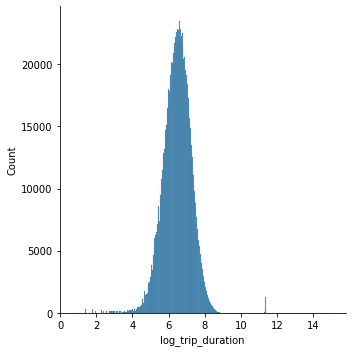

In [65]:
nycc['log_trip_duration']=np.log(nycc['trip_duration'].values+1)
sns.displot(nycc['log_trip_duration'], kde=False, bins=500)
plt.show()

1. There are several suspiciously short rides with less than 10 seconds duration
2. As discussed earlier, there are few huge outliers near 12.

{0: 60,
 1: 1033540,
 2: 210318,
 3: 59896,
 4: 28404,
 5: 78088,
 6: 48333,
 7: 3,
 8: 1,
 9: 1}

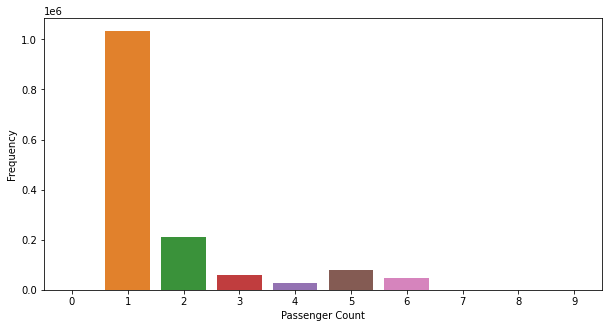

In [66]:
# Passenger count
plt.figure(figsize=(10,5))
sns.countplot(nycc['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

dict(nycc['passenger_count'].value_counts())

**Most of the trip involves only 1 passenger. There are trips with 7-9 passenger but they are very low in nummber.**

Text(0, 0.5, 'Frequency')

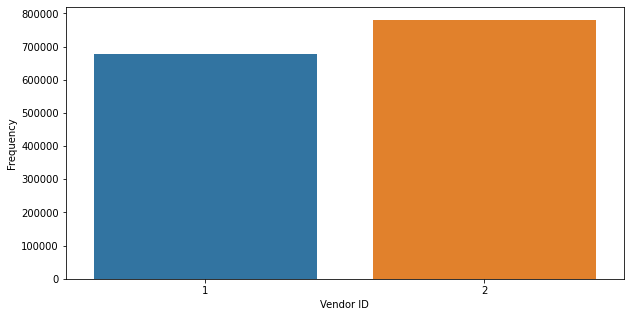

In [67]:
# Vendor count
plt.figure(figsize=(10,5))
sns.countplot(nycc['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('Frequency')

**Vendor 2 has more number of trips as compare to vendor1.**

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

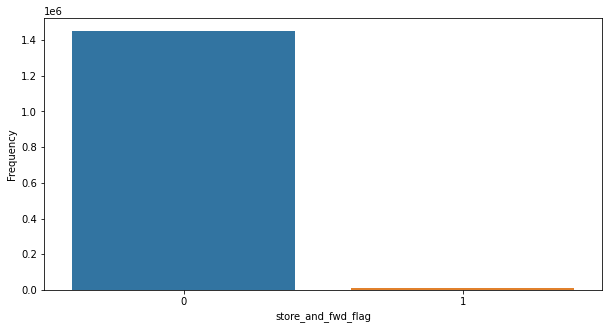

In [68]:
# store and fwd flag count
plt.figure(figsize=(10,5))
sns.countplot(nycc['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

nycc['store_and_fwd_flag'].value_counts()

**The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor('0') or held in the memory of the taxi because there was no connection to the server('1'), show that there was almost no storing taking place.**

In [69]:
# creating a new column(day_of_week) from the pickup_datetime column
nycc['day_of_week']=nycc['pickup_datetime'].dt.weekday
# creating a new column(hour_of_week) from the pickup_datetime column
nycc['hour_of_week']=nycc['pickup_datetime'].dt.hour

Text(0, 0.5, 'frequency')

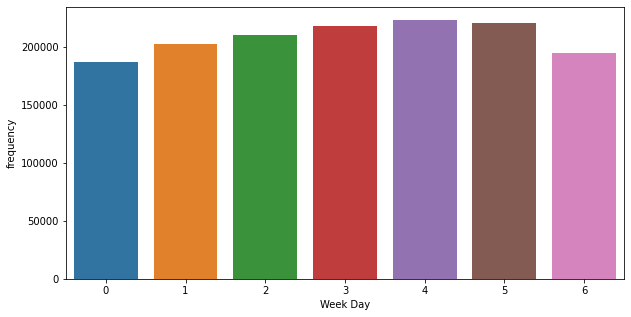

In [70]:
plt.figure(figsize=(10,5))
sns.countplot(nycc['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('frequency')

**Number of pickups for weekends is much lower than weeks days with a peak on Thurusday(4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday**

Text(0, 0.5, 'frequency')

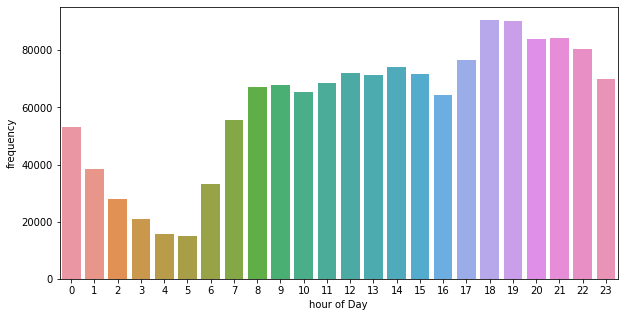

In [71]:
plt.figure(figsize=(10,5))
sns.countplot(nycc['hour_of_week'])
plt.xlabel('hour of Day')
plt.ylabel('frequency')

Number of pickups as expected is highest in late evening. However, it is much lower during the morning peak hours.

**Correlation Heatmap**

Let us quickly look at the correlation heatmap to check the correlation amongst all features.

In [72]:
nycc.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'day_of_week', 'hour_of_week'],
      dtype='object')

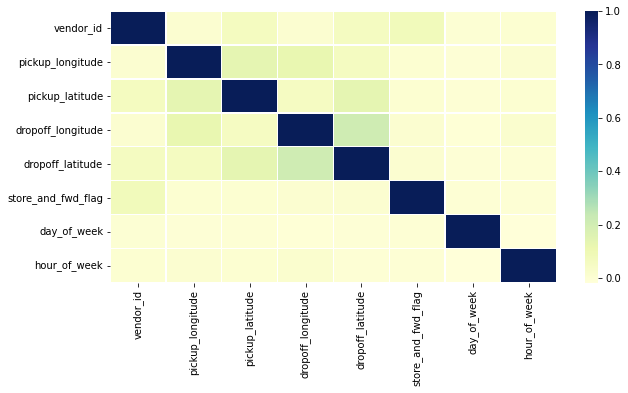

In [73]:
plt.figure(figsize=(10,5))
nycc=nycc.drop(['id','pickup_datetime','dropoff_datetime','passenger_count','trip_duration','log_trip_duration'], axis=1)
corr=nycc.apply(lambda x: pd.factorize(x)[0]).corr()
ax=sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.2, cmap="YlGnBu")

# **Data Preprocessing & Features Extraction**
We can only feed numeric features as input to our model. So our next task is to convert the features in numeric form. It is time to jump into getting our data ready for feeding into the model but before that it is important to use the variable to do some feature engineering.

Some of my ideas to create new variables and the reasons are as follows.

* Difference between pickup and dropoff latitude - will give as idea about the distance covered which could be predictive.
* Difference between pickup and dropoff longitude - same reason as above.
* Haversine distance between pickup and dropoff co-ordinate - to capture the actual distance travelled.
* Pickup minutes - Since picksecond is an important but the minute of pickup might well have been predictive.

In [ ]:
df=nyc.copy()
df.head()

In [75]:
#converting string to datetime function
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)


In [76]:
# log transformationn the Y value
df_y= np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:,'pickup_weekday']=df['pickup_datetime'].dt.weekday
df.loc[:,'pickup_hour_weekyear']=df['pickup_datetime'].dt.weekofyear
df.loc[:,'pickup_hour']=df['pickup_datetime'].dt.hour
df.loc[:,'pickup_minute']=df['pickup_datetime'].dt.minute
df.loc[:,'pickup_dt']=(df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:,'pickup_week_hour']=df['pickup_weekday'] * 24 + df['pickup_hour']

**Eucledian Distance** 

Let's calculate the eucledian distance between pickup and dropoff location to get some idea on how far the pickup and dropoff points are since this would definetely impact the trip duration even though we know that cars can't fly.


In [77]:
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist= df['pickup_latitude'] - df['dropoff_latitude']

# square distance
df['dist_sq'] = (y_dist**2) + (x_dist**2)

#distance
df['dist_sqrt'] = df['dist_sq']**0.5

In [78]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [79]:
#Calculate distance and assign new column to the dataframe.
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

**BINNING**

The latitude and longitude could be a bit noisy and it might be a good idea to bin them and create new features after rounding their values.

In [80]:
# Binned coordinates
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

**One Hot Encoding**

Here, Vendor ID can be cinverted to one hot encoding or frequency encoding since in the raw data it has value 1 and 2 without any inherent order.

In [81]:
df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Now, there is no much difference in the frequencies of both and that might not make for an important fratures so we will just convert it to 0 and 1 by subtracting 1 from it.

In [82]:
df['vendor_id']=df['vendor_id']-1

In [83]:
np.sum(pd.isnull(df))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_weekday              0
pickup_hour_weekyear        0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
dist_sq                     0
dist_sqrt                   0
distance                    0
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

Before  we go on to build a model, we must drop the variables that should not be fed as features to the algorithm. we will drop

* id -> Uniquely represented a sample in the train set.
* pickup_datetime and dropoff_datetime -> Since we have extracted the datetime features, there is no need to keep the datetime column
* trip_duratin -> this is the target variable so needs to dropped
* store_and_fwd_flag -> this variable is not available before the start of the trip and should not be used for modelling

In [85]:
df=df.drop(['id','pickup_datetime','dropoff_datetime','trip_duration','store_and_fwd_flag'],axis=1)

In [86]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sq,dist_sqrt,distance,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,11,17,24,6369878.0,17,0.000313,0.017680,1.498523,40.768,-73.982,40.768,-73.965
1,0,1,-73.980415,40.738564,-73.999481,40.731152,6,23,0,43,14085798.0,144,0.000418,0.020456,1.805510,40.739,-73.980,40.739,-73.999
2,1,1,-73.979027,40.763939,-74.005333,40.710087,1,3,11,35,1596907.0,35,0.003592,0.059934,6.385107,40.764,-73.979,40.764,-74.005
3,1,1,-74.010040,40.719971,-74.012268,40.706718,2,14,19,32,8364734.0,67,0.000181,0.013438,1.485500,40.720,-74.010,40.720,-74.012
4,1,1,-73.973053,40.793209,-73.972923,40.782520,5,12,13,30,7392638.0,133,0.000114,0.010690,1.188590,40.793,-73.973,40.793,-73.973


# **MODEL BUILDING**

In [87]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sq,dist_sqrt,distance,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,11,17,24,6369878.0,17,0.000313,0.017680,1.498523,40.768,-73.982,40.768,-73.965
1,0,1,-73.980415,40.738564,-73.999481,40.731152,6,23,0,43,14085798.0,144,0.000418,0.020456,1.805510,40.739,-73.980,40.739,-73.999
2,1,1,-73.979027,40.763939,-74.005333,40.710087,1,3,11,35,1596907.0,35,0.003592,0.059934,6.385107,40.764,-73.979,40.764,-74.005
3,1,1,-74.010040,40.719971,-74.012268,40.706718,2,14,19,32,8364734.0,67,0.000181,0.013438,1.485500,40.720,-74.010,40.720,-74.012
4,1,1,-73.973053,40.793209,-73.972923,40.782520,5,12,13,30,7392638.0,133,0.000114,0.010690,1.188590,40.793,-73.973,40.793,-73.973


# **Test Train split**
We have all numbers in our dataset now. Time to delve into model building. But before that, we need to finalize a validation strategy to create the train and test sets. Here, we will do a random split and keep one third of the data in test set and remaining two third of sata in the train set.

In [89]:
xtrain, xtest, ytrain, ytest = train_test_split(df, df_y,test_size=1/3, random_state=0)

In [91]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))
sqrt(mean_squared_error(ytest,mean_pred))

0.7932210515663911

In [92]:
# Transforming data
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [93]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
regressor.intercept_

27.308860241663822

In [95]:
regressor.coef_

array([ 1.78574774e-02,  5.74910032e-02, -4.11640817e+02,  1.29405316e+02,
        1.44609713e+02, -1.18035979e+01, -2.03874031e+13, -1.08760692e-01,
       -3.25632133e+12, -1.08307278e-02,  1.47980310e-01,  2.36437244e+13,
       -1.44839114e+02, -8.19114663e+01,  2.01729676e+02,  3.06268440e+08,
        3.86959964e+02, -3.06268557e+08, -1.45990744e+02])

In [99]:
y_pred_train = regressor.predict(xtrain)

In [96]:
# Predicting the Test set results
ypred = regressor.predict(xtest)

In [97]:
mean_squared_error(ytest, ypred)

0.37055410063881666

In [100]:
# Train performance
math.sqrt(mean_squared_error(ytrain, y_pred_train))

0.6175003699907595

In [102]:
# Test performance
math.sqrt(mean_squared_error(ytest, ypred))

0.608731550553129

In [103]:
r2_score(ytrain, y_pred_train)

0.3997526853141109

In [104]:
r2_score(ytest, ypred)

0.41107066485770505